In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import unet
import xarray as xr

In [2]:
def int_over_un(pred_fields, truth_fields):

    threshold = 1

    num_samples = pred_fields.shape[0]

    ious = []

    for sample in range(num_samples):
        # Set values above the threshold to 0 and the rest to 1
        pred_binary = np.where(pred_fields[sample] < threshold, 0, 1)
        truth_binary = np.where(truth_fields[sample] < threshold, 0, 1)
        
        # Calculate overlap: Intersection of both binary arrays
        intersection = np.sum(np.logical_and(pred_binary == 1, truth_binary == 1))
        union = np.sum(np.logical_or(pred_binary == 1, truth_binary == 1))
        
        # Divide by areafraction representation
        iou = intersection/union

        ious.append(iou)

    return ious

In [3]:
def plot_correlation(pred_fields, truth_fields):
    # Adjust values by subtracting 20
    pred_fields -= 20
    truth_fields -= 20

    # Create a mask to filter out very small/zero values
    mask = (pred_fields > -19) & (truth_fields > -19)
    pred_filtered = pred_fields[mask] 
    truth_filtered = truth_fields[mask]

    # Calculate Pearson correlation
    corr_coef, _ = pearsonr(pred_filtered.flatten(), truth_filtered.flatten())

    max_val = max(np.max(pred_filtered), np.max(truth_filtered))

    # Create the heatmap
    plt.figure(figsize=(8, 8))
    heatmap, xedges, yedges = np.histogram2d(
        pred_filtered.flatten(), 
        truth_filtered.flatten(), 
        bins=40,
        range=[[-19, max_val], [-19, max_val]]  # Explicit range
    )

    # Plot heatmap (with optional log scaling)
    plt.imshow(
        heatmap.T, 
        origin='lower', 
        cmap='viridis', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect='auto'
    )

    # Plot y = x line
    plt.plot([-19, max_val], [-19, max_val], 'r--', label='y=x')

    # Labels & title
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title(f'Heatmap of Predicted vs True Values\nCorrelation: {corr_coef:.2f}')
    plt.colorbar(label='Number of points')
    plt.legend()
    plt.grid()

    # Ensure axis limits include all data
    plt.xlim(-19, max_val)
    plt.ylim(-19, max_val)

    plt.savefig('model_eval_figs/correlation_plot.png')
    plt.show()

In [4]:
model_weights_path = 'models/unet_accumulated_100_lr001.pth'

# Load state_dict 
model = unet.UNET()  # Recreate model architecture
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
model.eval()  # set evaluation mode

# Load data
X_data = np.load('test_set.npz')['X_test']
y_test = np.load('test_set.npz')['y_test']

num_samples = X_data.shape[0]
# Preallocate NumPy arrays for predictions and truths
pred_conc_array = np.empty((num_samples, *y_test.shape[1:]))  # Define output_shape based on model output
true_conc_array = np.empty((num_samples, *y_test.shape[1:]))  

for sample in range(num_samples):
    
    # Get truth
    truth_conc = y_test[sample]
    
    # Generate prediction from model
    input_stack = X_data[sample]
    
    # Convert to tensor (add batch dimension)
    input_tensor = torch.from_numpy(input_stack[np.newaxis, ...]).float()
    
    # Make prediction
    with torch.no_grad():
        output_tensor = model(input_tensor)
    
    # Get prediction and store in pre-allocated array
    pred_conc = output_tensor.numpy().squeeze()
    
    pred_conc_array[sample] = pred_conc
    true_conc_array[sample] = truth_conc

/tmp/ipykernel_3940909/7042225.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

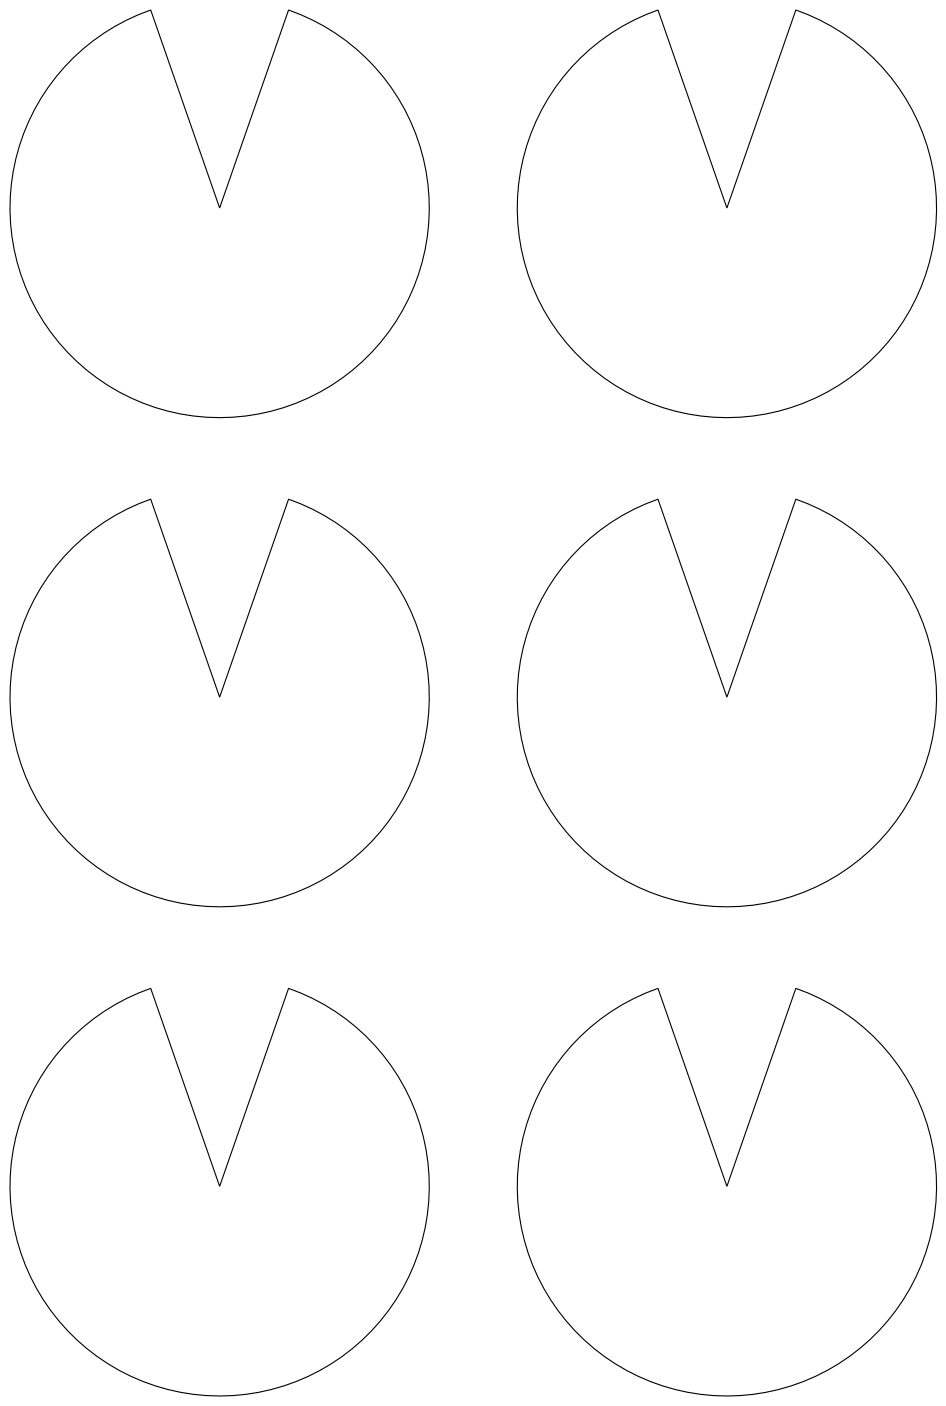

In [6]:
import sys
import random

# Specify the path to the directory containing the .py file
path_to_module = '/lustre/storeB/users/chbou7748/snap_tools/'
sys.path.append(path_to_module)

import snap_map  

snap_map.plot_var_unet(pred_conc_array, true_conc_array, var='PMCH_acc_concentration', scale='linear', maxval=0, minval=-19)
    

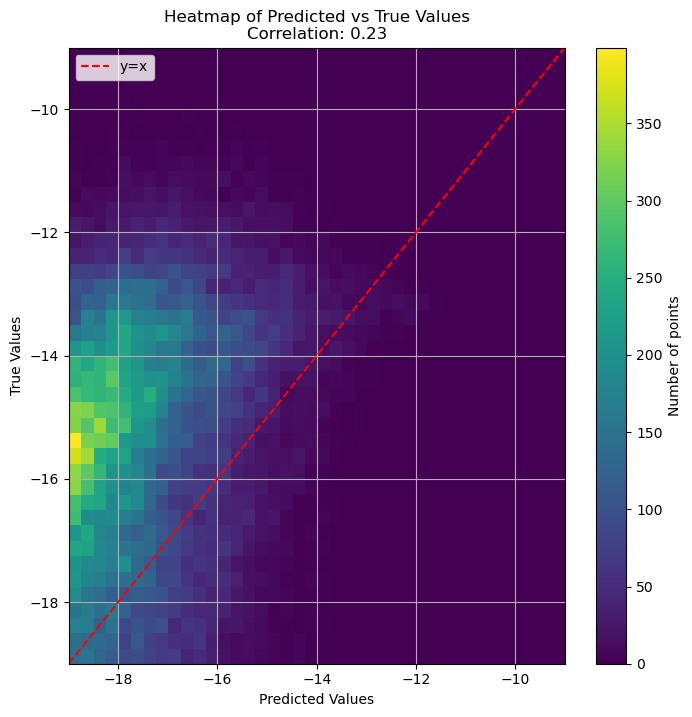

In [ ]:
spatial_acc = int_over_un(pred_conc_array, true_conc_array)
plot_correlation(pred_conc_array, true_conc_array)